<a href="https://colab.research.google.com/github/Giovanni-LN/Projeto_RN/blob/main/Rede_Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar e preparar o Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho para o dataset no Google Drive
data_dir = "/content/drive/MyDrive/MyFoodDataset"

# Transformações para normalização e Data Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
        transforms.RandomRotation(10),      # Rotação aleatória
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalização
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Carregar as imagens
image_datasets = {
    x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Criar DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val', 'test']
}

# Verificar as classes
class_names = image_datasets['train'].classes
print("Classes detectadas:", class_names)

# Testar carregamento de um batch
images, labels = next(iter(dataloaders['train']))
print("Tamanho do batch:", images.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes detectadas: ['apple', 'bean', 'boiled', 'chicken', 'fried', 'lunch', 'rice', 'salad', 'spaghetti', 'steak']
Tamanho do batch: torch.Size([32, 3, 224, 224])


# Mapear as Classes

In [ ]:
class_mapping = {
    'apple': 'Maçã',
    'bean': 'Feijão',
    'boiled': 'Ovo Cozido',
    'chicken': 'Peito de Frango',
    'fried': 'Ovo Frito',
    'lunch': 'Almoço',
    'rice': 'Arroz',
    'salad': 'Salada',
    'spaghetti': 'Macarrão',
    'steak': 'Carne Assada'
}

# Criar a lista de classes traduzidas
filtered_class_names = [class_mapping[cls] for cls in class_names]
print("Classes finais mapeadas:", filtered_class_names)


Classes finais mapeadas: ['Maçã', 'Feijão', 'Ovo Cozido', 'Peito de Frango', 'Ovo Frito', 'Almoço', 'Arroz', 'Salada', 'Macarrão', 'Carne Assada']


# Verificar se os dados carregados e o mapeamento das classes estão funcionando

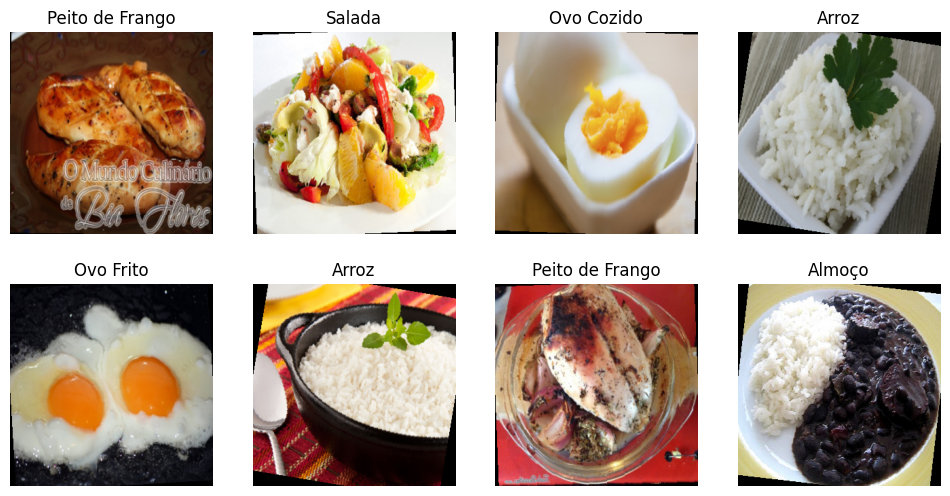

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Função para mostrar um batch de imagens
def imshow(inp, title=None):
    """Imprime uma imagem do tensor"""
    inp = inp.numpy().transpose((1, 2, 0))  # Ajusta para formato correto (Altura, Largura, Canais)
    mean = np.array([0.5, 0.5, 0.5])  # Valores usados na normalização
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean  # Desfaz a normalização
    inp = np.clip(inp, 0, 1)  # Garante que os valores estão no intervalo [0,1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# Pegar um batch do dataloader de treino
inputs, labels = next(iter(dataloaders['train']))

# Criar grid com algumas imagens
fig = plt.figure(figsize=(12, 6))
for i in range(8):  # Exibir 8 imagens
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    imshow(inputs[i])
    ax.set_title(filtered_class_names[labels[i].item()])  # Nome traduzido da classe

plt.show()


# Criar os DataLoaders

In [ ]:
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val', 'test']
}

# Verificar as classes
class_names = image_datasets['train'].classes
print("Classes detectadas:", class_names)

# Testar carregamento de um batch
images, labels = next(iter(dataloaders['train']))
print("Tamanho do batch:", images.shape)

Classes detectadas: ['apple', 'bean', 'boiled', 'chicken', 'fried', 'lunch', 'rice', 'salad', 'spaghetti', 'steak']
Tamanho do batch: torch.Size([32, 3, 224, 224])


#  Importações e Configurações Iniciais

In [ ]:
# Importações necessárias
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Definir o dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}\n")

Usando dispositivo: cuda



# Carregamento e Modificação do Modelo


In [ ]:
# Carregar o modelo Inception v3 pré-treinado
model_inception = models.inception_v3(weights="IMAGENET1K_V1")

# Modificar a última camada para 10 classes
num_classes = 10
model_inception.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout com 50% de probabilidade
    nn.Linear(model_inception.fc.in_features, num_classes)
)

# Enviar o modelo para o dispositivo escolhido
model_inception = model_inception.to(device)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_inception.parameters(), lr=0.0001)

# Mostrar a estrutura do modelo modificado
print("Estrutura do modelo Inception v3 modificado:")
print(model_inception)
print("\n")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 105MB/s] 


Estrutura do modelo Inception v3 modificado:
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (co

# Preparação dos Dados

In [ ]:
# Definir transformações para os conjuntos de treino, validação e teste
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((299, 299)),  # Redimensionar para 299x299
        transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
        transforms.RandomRotation(10),      # Rotação aleatória
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalização
    ]),
    'val': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Carregar datasets (substitua pelo caminho do seu conjunto de dados)
data_dir = "/content/drive/MyDrive/MyFoodDataset"
datasets_dict = {x: datasets.ImageFolder(f"{data_dir}/{x}", transform=data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(datasets_dict[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

print("Dados carregados e transformações aplicadas.\n")

Dados carregados e transformações aplicadas.



# Treinamento do Modelo

In [ ]:
# Função de treinamento
def train_model_inception(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"Época {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Modo de treino
            else:
                model.eval()  # Modo de validação

            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    if phase == "train":
                        # Modelo Inception possui saída auxiliar para o treinamento
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2  # Peso na saída auxiliar
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct.double() / total

            print(f"{phase} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
        print("-" * 40)

    return model

# Treinar o modelo
print("Iniciando treinamento...\n")
model_inception_trained = train_model_inception(model_inception, dataloaders, criterion, optimizer, num_epochs=5)
print("Treinamento concluído.\n")

Iniciando treinamento...

Época 1/5
train | Loss: 3.0807 | Acc: 0.4680
val | Loss: 0.8652 | Acc: 0.8880
----------------------------------------
Época 2/5
train | Loss: 0.7041 | Acc: 0.9080
val | Loss: 0.2808 | Acc: 0.9360
----------------------------------------
Época 3/5
train | Loss: 0.2565 | Acc: 0.9653
val | Loss: 0.1574 | Acc: 0.9640
----------------------------------------
Época 4/5
train | Loss: 0.1087 | Acc: 0.9960
val | Loss: 0.1300 | Acc: 0.9640
----------------------------------------
Época 5/5
train | Loss: 0.0766 | Acc: 0.9947
val | Loss: 0.1155 | Acc: 0.9640
----------------------------------------
Treinamento concluído.



# Avaliação do Modelo no Conjunto de Teste

In [ ]:
# Função de avaliação
def evaluate_model_inception(model, dataloader, criterion, device):
    model.eval()  # Modo de avaliação
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    print(f"Test Loss: {epoch_loss:.4f} | Test Acc: {epoch_acc:.4f}")
    return epoch_acc, all_preds, all_labels

# Avaliação no conjunto de teste
print("Avaliando o modelo no conjunto de teste...")
test_accuracy_inception, test_preds, test_labels = evaluate_model_inception(model_inception_trained, dataloaders['test'], criterion, device)
print("Avaliação concluída.\n")

Avaliando o modelo no conjunto de teste...
Test Loss: 0.1460 | Test Acc: 0.9560
Avaliação concluída.



# Cálculo da Média e Desvio Padrão da Acurácia

In [ ]:
# Cálculo da média e do desvio padrão da acurácia
num_runs = 10  # Número de execuções para calcular média e desvio padrão
accuracies_inception = []

print("Calculando média e desvio padrão da acurácia...")
for i in range(num_runs):
    print(f"Execução {i+1}/{num_runs}...")
    acc, _, _ = evaluate_model_inception(model_inception_trained, dataloaders['test'], criterion, device)
    accuracies_inception.append(acc)

mean_acc_inception = np.mean(accuracies_inception)
std_acc_inception = np.std(accuracies_inception)

print("\nResultados:")
print(f"Média da Acurácia (Inception): {mean_acc_inception:.4f}")
print(f"Desvio Padrão da Acurácia (Inception): {std_acc_inception:.4f}\n")

Calculando média e desvio padrão da acurácia...
Execução 1/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 2/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 3/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 4/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 5/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 6/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 7/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 8/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 9/10...
Test Loss: 0.1460 | Test Acc: 0.9560
Execução 10/10...
Test Loss: 0.1460 | Test Acc: 0.9560

Resultados:
Média da Acurácia (Inception): 0.9560
Desvio Padrão da Acurácia (Inception): 0.0000



# Matriz de Confusão

Gerando matriz de confusão...


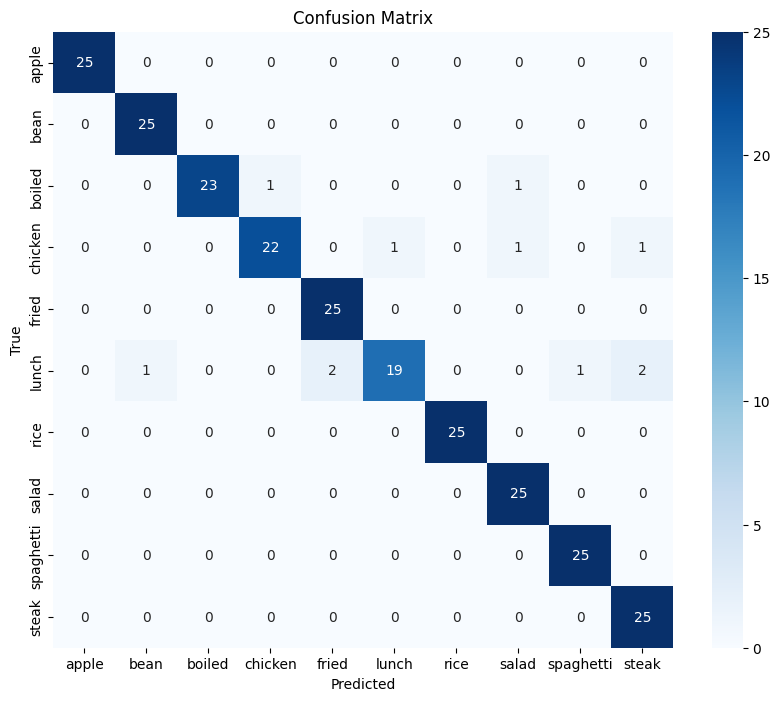

Matriz de confusão gerada.



In [ ]:
# Matriz de confusão
print("Gerando matriz de confusão...")
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=datasets_dict['test'].classes, yticklabels=datasets_dict['test'].classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print("Matriz de confusão gerada.\n")

# Testes Individuais em Imagens

In [ ]:
# Função para prever a classe de uma imagem individual
def predict_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return datasets_dict['test'].classes[preds[0]]

# Exemplo de uso
print("Realizando teste individual em uma imagem...")
image_path = "/content/drive/MyDrive/MyFoodDataset/test/apple/apple_100.png"
predicted_class = predict_image(model_inception_trained, image_path, data_transforms['test'], device)
print(f"Predicted Class: {predicted_class}\n")

Realizando teste individual em uma imagem...
Predicted Class: apple



# T-SNE e PCA

Essas técnicas reduzem a dimensionalidade dos dados e ajudam a visualizar como o modelo organiza as classes.

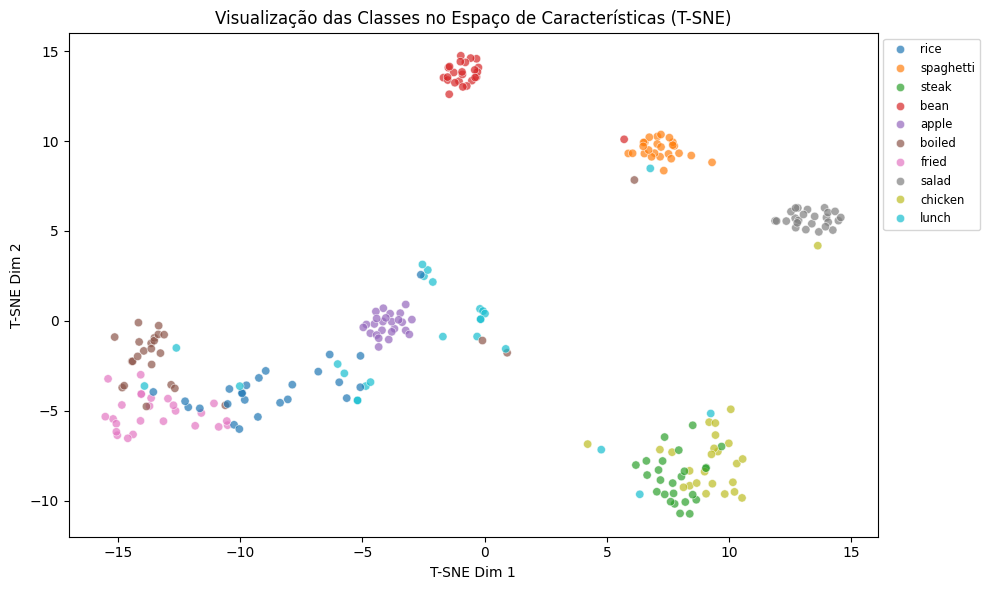

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_features(model, dataloader, device):
    """
    Extrai as características (embeddings) da penúltima camada do modelo.

    Args:
        model: Modelo de rede neural.
        dataloader: DataLoader para o conjunto de dados.
        device: Dispositivo (CPU ou GPU).

    Returns:
        features: Array com as características extraídas.
        labels_list: Array com os rótulos correspondentes.
    """
    model.eval()
    features, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            # Extrai as características da penúltima camada
            if model.training: # Check if model is in training mode
                outputs, aux_outputs = model(inputs)  # Inception v3 tem duas saídas
            else:
                outputs = model(inputs) # Use single output if in eval mode
            features.append(outputs.cpu().numpy())  # Usamos a saída principal
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)

    return features, labels_list

# Extrai os embeddings do modelo
features, labels = extract_features(model_inception_trained, dataloaders['test'], device)

# PCA para redução de dimensionalidade inicial
pca = PCA(n_components=2)  # Reduz para 2 componentes
features_pca = pca.fit_transform(features)

# Aplicar T-SNE para visualizar em 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # perplexity pode ser ajustado
features_tsne = tsne.fit_transform(features_pca)

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=features_tsne[:, 0],
    y=features_tsne[:, 1],
    hue=[datasets_dict['test'].classes[i] for i in labels],  # Nomes das classes
    palette="tab10",  # Paleta de cores
    alpha=0.7  # Transparência dos pontos
)
plt.xlabel("T-SNE Dim 1")
plt.ylabel("T-SNE Dim 2")
plt.title("Visualização das Classes no Espaço de Características (T-SNE)")
plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1, 1))  # Legenda fora do gráfico
plt.tight_layout()  # Ajustar layout
plt.show()